# Setup

**Imports**

In [1]:
!pip install ruptures

In [1]:
import datetime as dt
from math import log
import IPython

import matplotlib.pyplot as plt
import numpy as np
import ruptures as rpt
from scipy.signal import spectrogram, correlate
from scipy.fft import fft, ifft
from collections import defaultdict


rng = np.random.default_rng()

# Question 1

The following cell loads the training data set `X_train` and `y_train`.
`X_train` is a list of 100 signals; `y_train` is a list of 100 symbol sequences.

The signals have a varying number of symbols with a varying duration.
There is a brief silence between each symbol.
The sampling frequency is $22.05 $ kHz.

In [3]:
FS = 22050  # sampling frequency (Hz)

X_train = np.load("X_train.npy", allow_pickle=True).tolist()
y_train = np.load("y_train.npy", allow_pickle=True).tolist()

In [4]:
signal, symbols = X_train[4], y_train[4]
print(" ".join(symbols))
IPython.display.Audio(signal, rate=FS)

5 C C 9 # 7 C C 4


## First we visualize our problem statement

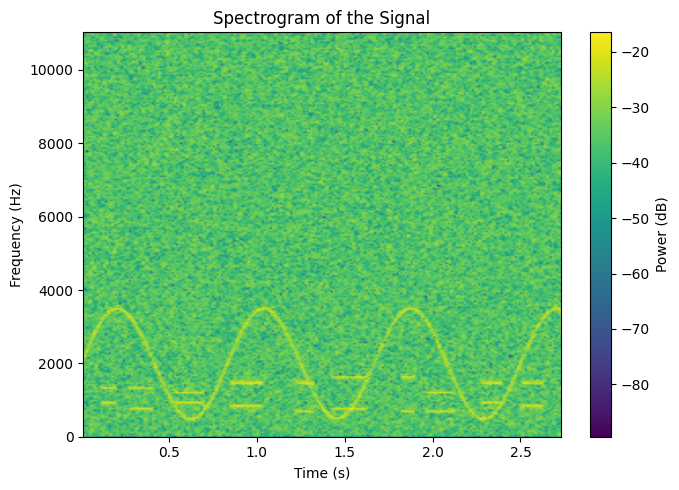

In [5]:

idx = 14
signal, symbols = X_train[idx], y_train[idx]

# Spectrogramme
frequencies, times, Sxx = spectrogram(signal, fs=FS, nperseg=512, noverlap=256)

freq_min = float("-inf")#600
freq_max = float("inf")#2000
mask = (frequencies >= freq_min) & (frequencies <= freq_max)
frequencies = frequencies[mask]
Sxx = Sxx[mask, :]

plt.figure(figsize=(7, 5))

plt.pcolormesh(times, frequencies, 10 * np.log10(Sxx), shading='gouraud')
plt.title("Spectrogram of the Signal")
plt.ylabel("Frequency (Hz)")
plt.xlabel("Time (s)")
plt.colorbar(label="Power (dB)")
plt.tight_layout()
plt.show()


Observing the spectrogram across multiple samples quickly reveals that our sounds and fundamental frequencies lie between 600 and 2000 Hz. To simplify calculations and avoid issues with autocorrelation, we truncate the spectrogram to this range. Next, we identify the frequencies with the highest autocorrelations, focusing only on those above a minimum threshold to exclude white noise.

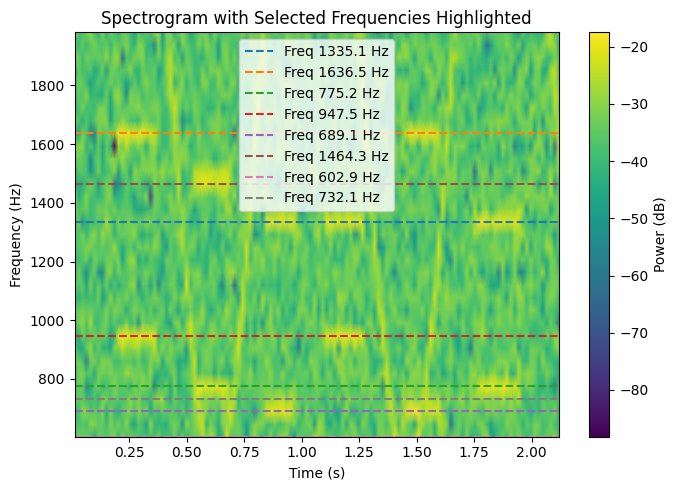

['D', '6', '2', '0', 'A', '5']


In [6]:
def select_top_frequencies(signal, fs, n=8, v=0.0002, nperseg=512, noverlap=128, plot=False):

    # Spectrogramme
    frequencies, times, Sxx = spectrogram(signal, fs=fs, nperseg=nperseg, noverlap=noverlap)

    # Filter
    freq_min, freq_max = 600, 2000
    mask = (frequencies >= freq_min) & (frequencies <= freq_max)
    frequencies = frequencies[mask]
    Sxx = Sxx[mask, :]

    # Autocorrelation
    autocorr_values = []
    for i in range(Sxx.shape[0]):
        power = Sxx[i, :]
        autocorr = correlate(power, power, mode='full')
        autocorr = autocorr[autocorr.size // 2:]
        autocorr_values.append(np.max(autocorr))

    valid_indices = [i for i, value in enumerate(autocorr_values) if value > v]

    valid_indices_sorted = sorted(valid_indices, key=lambda i: autocorr_values[i], reverse=True)

    # n highest autocorrelation frquencies
    top_indices = valid_indices_sorted[:n]
    selected_frequencies = frequencies[top_indices]

    # Vis
    if plot:
        plt.figure(figsize=(7, 5))
        plt.pcolormesh(times, frequencies, 10 * np.log10(Sxx), shading='gouraud')
        for idx in top_indices:
            plt.plot(times, [frequencies[idx]] * len(times), label=f"Freq {frequencies[idx]:.1f} Hz", linestyle='--')
        plt.title("Spectrogram with Selected Frequencies Highlighted")
        plt.ylabel("Frequency (Hz)")
        plt.xlabel("Time (s)")
        plt.colorbar(label="Power (dB)")
        plt.legend()
        plt.tight_layout()
        plt.show()

    return selected_frequencies, top_indices

idx = 18
signal, symbols = X_train[idx], y_train[idx]

selected_frequencies, top_indices = select_top_frequencies(signal, FS, n=8, v=0.0002, plot=True)
print(symbols)


Using the previous code, we can easily and manually determine the dictionary mapping frequencies to their corresponding symbols.

In [7]:
sym2freq = {
    '0' : (947.5,1335.1),
    '1' : (687.5,1205.9),
    '2' : (687.5,1335.1),
    '3' : (687.5,1464.3),
    '4' : (775.2,1205.9),
    '5' : (775.2,1335.1),
    '6' : (775.2,1464.3),
    '7' : (861.3,1205.9),
    '8' : (861.3,1335.1),
    '9' : (861.3,1464.3),
    '*' : (947.5,1205.9),
    '#' : (947.5,1464.3),
    'A' : (687.5,1636.5),
    'B' : (775.2,1636.5),
    'C' : (861.3,1636.5),
    'D' : (947.5,1636.5),
}

freq2sym = {v: k for k, v in sym2freq.items()}

In [8]:

def remove_white_noise(signal, fs, noise_threshold=-24):
    # Compute the Fourier Transform of the signal
    fft_values = fft(signal)
    frequencies = np.fft.fftfreq(len(signal), 1 / fs)

    # Remove noise components below the threshold
    fft_values[np.abs(fft_values) < noise_threshold * np.max(np.abs(fft_values))] = 0

    # Perform the inverse Fourier Transform to reconstruct the filtered signal
    filtered_signal = np.real(ifft(fft_values))

    return filtered_signal

def merge_intervals_by_frequency(intervals_dict):
    # Collect all intervals into a single list
    all_intervals = []
    for freq, intervals in intervals_dict.items():
        for start, end in intervals:
            all_intervals.append((start, end, freq))

    # Sort intervals by their start times
    all_intervals.sort(key=lambda x: x[0])

    # Merge intervals that overlap or are adjacent
    merged_intervals = []
    current_start, current_end, current_freqs = all_intervals[0][0], all_intervals[0][1], {all_intervals[0][2]}

    for start, end, freq in all_intervals[1:]:
        if start <= current_end:  # Overlapping or adjacent intervals
            current_end = max(current_end, end)
            current_freqs.add(freq)
        else:
            merged_intervals.append((current_start, current_end, current_freqs))
            current_start, current_end, current_freqs = start, end, {freq}

    # Add the last interval
    merged_intervals.append((current_start, current_end, current_freqs))

    # Organize merged intervals into a dictionary by frequency
    merged_intervals_dict = {}
    for start, end, freqs in merged_intervals:
        for freq in freqs:
            if freq not in merged_intervals_dict:
                merged_intervals_dict[freq] = []
            merged_intervals_dict[freq].append((start, end))

    return merged_intervals_dict

def select_top_frequencies_with_breakpoints(signal, fs, n=8, v=0.0005, nperseg=600, noverlap=100, threshold_db=-24, plot=False):
    # Remove white noise from the signal
    filtered_signal = remove_white_noise(signal, fs)

    # Compute the spectrogram
    frequencies, times, Sxx = spectrogram(filtered_signal, fs=fs, nperseg=nperseg, noverlap=noverlap)

    # Filter frequencies between 600 Hz and 2000 Hz
    freq_min, freq_max = 600, 2000
    mask = (frequencies >= freq_min) & (frequencies <= freq_max)
    frequencies = frequencies[mask]
    Sxx = Sxx[mask, :]

    # Compute autocorrelation for each frequency
    autocorr_values = []
    for i in range(Sxx.shape[0]):
        power = Sxx[i, :]
        autocorr = correlate(power, power, mode='full')
        autocorr = autocorr[autocorr.size // 2:]  # Keep the positive lags
        autocorr_values.append(np.max(autocorr))

    # Select indices of frequencies with autocorrelation > v
    valid_indices = [i for i, value in enumerate(autocorr_values) if value > v]
    valid_indices_sorted = sorted(valid_indices, key=lambda i: autocorr_values[i], reverse=True)

    # Select the top n frequencies
    top_indices = valid_indices_sorted[:n]
    selected_frequencies = frequencies[top_indices]

    # Detect breakpoints for selected frequencies
    breakpoints_dict = {}
    for idx in top_indices:
        power_at_frequency = 10 * np.log10(Sxx[idx, :] + 1e-12)  # Convert to dB
        above_threshold = power_at_frequency > threshold_db  # Find values above the threshold
        intervals = []
        start = None

        # Identify continuous regions above the threshold
        for i, above in enumerate(above_threshold):
            if above and start is None:
                start = i
            elif not above and start is not None:
                end = i - 1
                intervals.append((times[start], times[end]))
                start = None
        if start is not None:
            intervals.append((times[start], times[-1]))

        breakpoints_dict[frequencies[idx]] = intervals

    # Merge intervals across all frequencies
    merged_intervals_dict = merge_intervals_by_frequency(breakpoints_dict)

    # Plot the spectrogram with selected frequencies and intervals
    if plot:
        plt.figure(figsize=(10, 6))
        plt.pcolormesh(times, frequencies, 10 * np.log10(Sxx), shading='gouraud')

        # Plot horizontal lines for selected frequencies
        for idx in top_indices:
            plt.plot(times, [frequencies[idx]] * len(times), label=f"Freq {frequencies[idx]:.1f} Hz", linestyle='--')

        # Plot vertical lines for merged intervals
        for freq, intervals in merged_intervals_dict.items():
            for start, end in intervals:
                plt.axvline(x=start, color='red', linestyle='--', alpha=0.7)
                plt.axvline(x=end, color='orange', linestyle='--', alpha=0.7)

        plt.title("Spectrogram with Selected Frequencies and Merged Breakpoints")
        plt.ylabel("Frequency (Hz)")
        plt.xlabel("Time (s)")
        plt.colorbar(label="Power (dB)")
        plt.legend()
        plt.tight_layout()
        plt.show()

    return selected_frequencies, merged_intervals_dict


In [9]:
from collections import defaultdict

def map_intervals_to_symbols(merged_intervals_dict, sym2freq, freq2sym):

    # Step 1: Get all unique frequencies from sym2freq
    unique_freqs = sorted(set(freq for pair in sym2freq.values() for freq in pair))

    # Helper function to find the closest frequency
    def find_closest_freq(freq, unique_freqs):
        return min(unique_freqs, key=lambda x: abs(x - freq))

    # Step 2: Map frequencies in merged_intervals_dict to their closest values in sym2freq
    mapped_intervals = defaultdict(list)
    for freq, intervals in merged_intervals_dict.items():
        closest_freq = find_closest_freq(freq, unique_freqs)
        mapped_intervals[closest_freq].extend(intervals)

    # Step 3: Create a list of events (start and end times for each interval)
    events = []
    for freq, intervals in mapped_intervals.items():
        for interval in intervals:
            start, end = interval
            events.append((start, 'start', freq))
            events.append((end, 'end', freq))

    # Step 4: Sort events by time, with 'start' before 'end' if times are equal
    events.sort(key=lambda x: (x[0], 0 if x[1] == 'start' else 1))

    # Step 5: Process events to identify active symbols
    active_freqs = set()
    last_time = None
    current_symbol = None
    symbol_list = []

    for event in events:
        time, event_type, freq = event

        # Add the current symbol to the list if time has advanced
        if last_time is not None and time > last_time:
            if current_symbol:
                symbol_list.append(current_symbol)

        # Update the set of active frequencies
        if event_type == 'start':
            active_freqs.add(freq)
        elif freq in active_freqs:  # Ensure the frequency is active before removing it
            active_freqs.remove(freq)
        else:
            print(f"Warning: Tried to remove frequency {freq} that is not active. Event: {event}")

        # Determine the current symbol based on active frequencies
        if len(active_freqs) >= 2:
            sorted_freqs = sorted(active_freqs)
            found = False
            # Check all pairs of active frequencies
            for i in range(len(sorted_freqs)):
                for j in range(i + 1, len(sorted_freqs)):
                    freq_pair = (sorted_freqs[i], sorted_freqs[j])
                    symbol = freq2sym.get(freq_pair)
                    if symbol:
                        current_symbol = symbol
                        found = True
                        break
                if found:
                    break
            if not found:
                current_symbol = None
        else:
            current_symbol = None

        # Update the last processed time
        last_time = time

    return symbol_list


In [10]:
def total_pipeline(signal, fs, n=8, v=0.0001, nperseg=600, noverlap=100, threshold_db=-22, plot=True,sym2freq = sym2freq,freq2sym = freq2sym):
  selected_frequencies, merged_intervals_dict = select_top_frequencies_with_breakpoints(
      signal = signal, fs = fs, n=n, v=v, plot=plot, threshold_db=threshold_db, nperseg=nperseg, noverlap=noverlap
  )
  symbols = map_intervals_to_symbols(merged_intervals_dict, sym2freq, freq2sym)
  return symbols

"""
idx = 6
signal, symbols = X_train[idx], y_train[idx]

print("Symbols estimé : ",total_pipeline(signal,FS))
print("Vrai symbols :",symbols)"""

'\nidx = 6\nsignal, symbols = X_train[idx], y_train[idx]\n\nprint("Symbols estimé : ",total_pipeline(signal,FS))\nprint("Vrai symbols :",symbols)'

# Question 2

2
Sample :  0


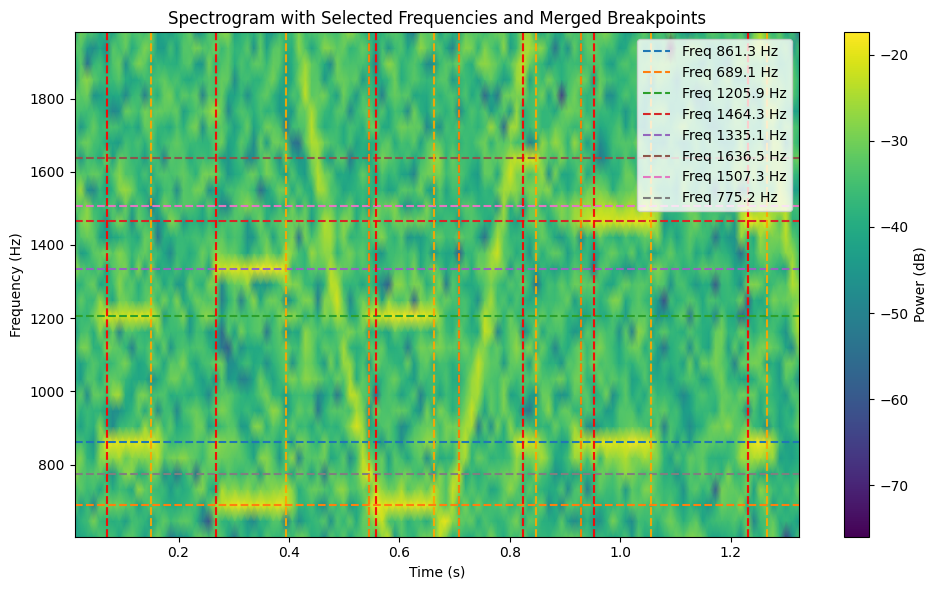

Symbols estimé :  ['7', '2', '1', 'C', '9', '9']
Vrai symbols : ['7', '2', '1', 'C', '9', '9']
Sample :  1


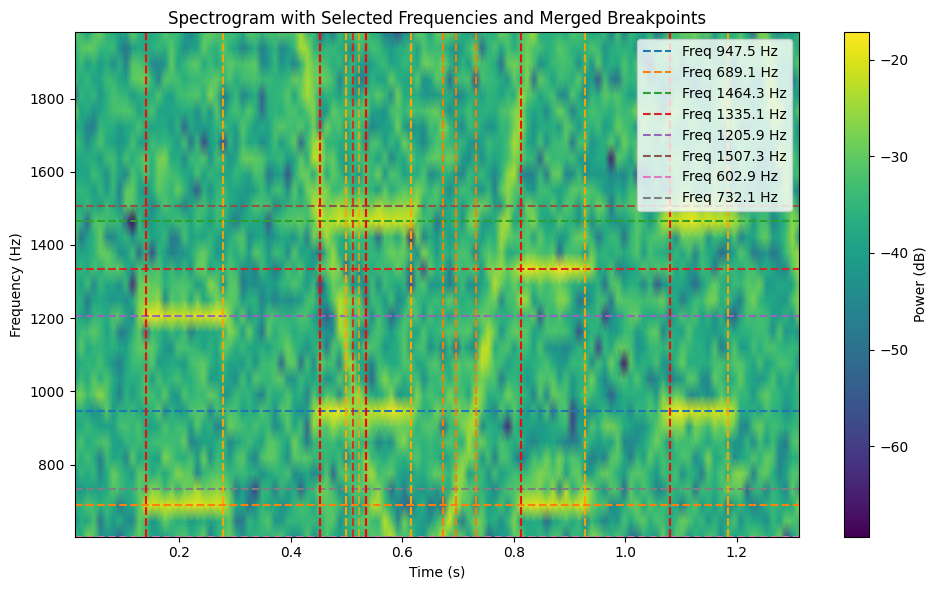

Symbols estimé :  ['1', '#', '3', '2', '#']
Vrai symbols : ['1', '#', '2', '#']


In [11]:
X_test = np.load("X_test.npy", allow_pickle=True).tolist()
y_test = np.load("y_test.npy", allow_pickle=True).tolist()
print(len(X_test))

for i in range(len(X_test)):
  print("Sample : ",i)
  signal, symbols = X_test[i], y_test[i]
  print("Symbols estimé : ",total_pipeline(signal,FS,plot = True,threshold_db= -22,noverlap= 256, nperseg= 512))
  print("Vrai symbols :",symbols)



# Question 3

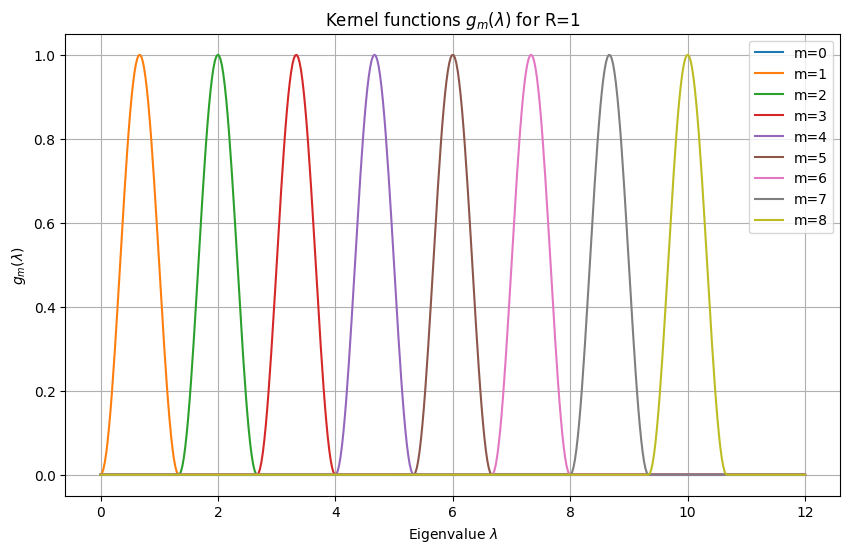

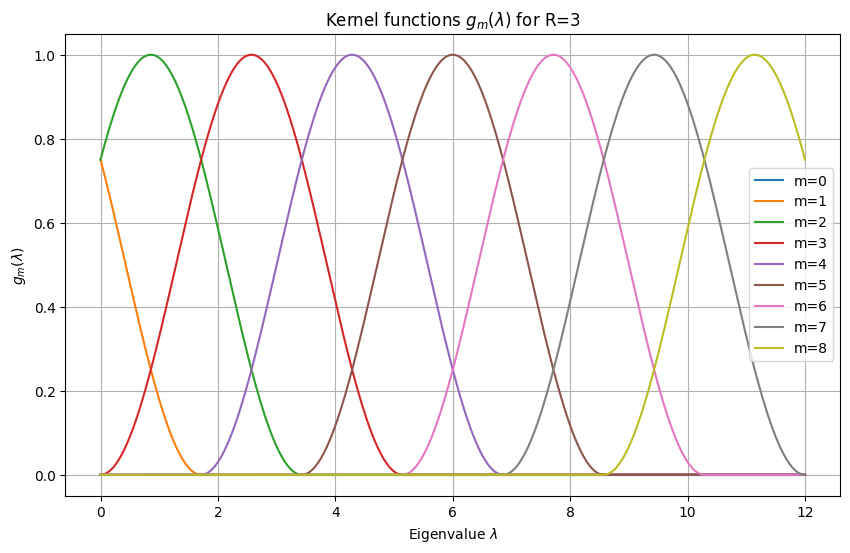

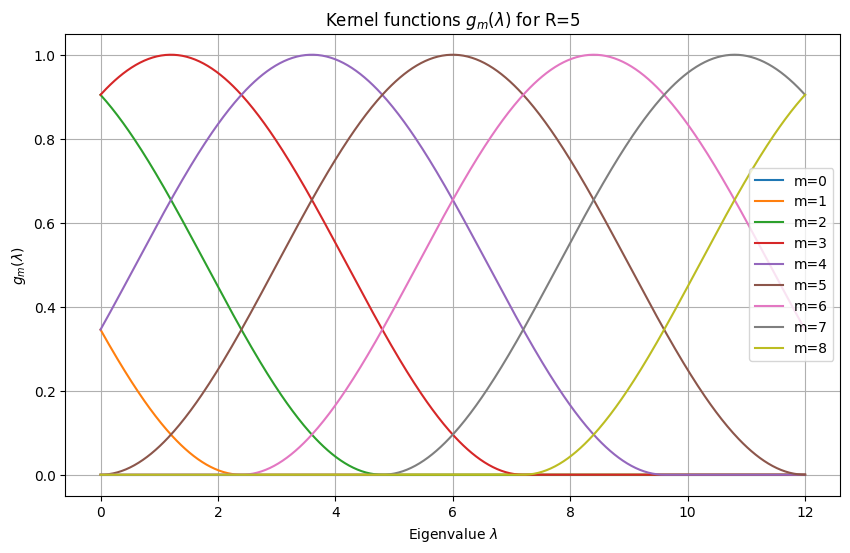

In [5]:
def g_m(lamb, m, M, R):
    lambda_n = 12
    a = lambda_n / (M + 1 - R)

    def g_u(x):
        return np.where(
            (-R * a <= x) & (x < 0),
            1 / 2 * (1 + np.cos(2 * np.pi * (x / (a * R) + 1 / 2))),
            0,
        )


    return g_u(lamb - a * m) * ((0 <= lamb) & (lamb <= lambda_n)) # here boolean condition and not a if for array compatibility

# Parameters
M = 9
m_list = np.arange(0, M)  
lambda_n, eigenvalues_number = 12, 500
eigenvalues = np.linspace(0, lambda_n, eigenvalues_number)

# Boucle sur les valeurs de R et m
for R in [1, 3, 5]:
    plt.figure(figsize=(10, 6))

    for m in m_list:

        current_g_m = g_m(eigenvalues, m, M, R)
        plt.plot(eigenvalues, current_g_m, label=f"m={m}")

    # Configurer le graphique
    plt.title(f"Kernel functions $g_m(\\lambda)$ for R={R}")
    plt.xlabel("Eigenvalue $\\lambda$")
    plt.ylabel("$g_m(\\lambda)$")
    plt.legend()
    plt.grid()


    plt.savefig(f'plots_q3/R_{R}.png', bbox_inches='tight')
    plt.show()


# Question 4

In [6]:
!mkdir plots_q4

Un sous-r‚pertoire ou un fichier plots_q4 existe d‚j….


In [7]:
from loadmydata.load_molene_meteo import load_molene_meteo_dataset

# load data
data_df, stations_df, description = load_molene_meteo_dataset()


data_df["temp"] = data_df['t'] - 273.15  # convert temperature in Celsius

data_df.head()

numer_sta                date         date_insert  td       t      tx  \
0   22016001 2014-01-01 00:00:00 2014-01-01 00:13:55 NaN  280.15  281.35   
1   22016001 2014-01-01 01:00:00 2014-01-01 01:07:59 NaN  280.15  280.25   
2   22016001 2014-01-01 02:00:00 2014-01-01 02:08:05 NaN  280.95  280.95   
3   22016001 2014-01-01 03:00:00 2014-01-01 03:08:09 NaN  281.45  281.45   
4   22016001 2014-01-01 04:00:00 2014-01-01 04:08:14 NaN  282.05  282.05   

       tn   u  ux  un  ...  vv  etat_sol  sss   n  insolh  ray_glo01  pres  \
0  280.15 NaN NaN NaN  ... NaN       NaN  NaN NaN     0.0        0.0   NaN   
1  279.65 NaN NaN NaN  ... NaN       NaN  NaN NaN     0.0        0.0   NaN   
2  280.15 NaN NaN NaN  ... NaN       NaN  NaN NaN     0.0        0.0   NaN   
3  280.95 NaN NaN NaN  ... NaN       NaN  NaN NaN     0.0        0.0   NaN   
4  281.45 NaN NaN NaN  ... NaN       NaN  NaN NaN     0.0        0.0   NaN   

   pmer   station_name  temp  
0   NaN  ILE-DE-BREHAT   7.0  
1   NaN  ILE-DE-BREHAT   7.0  
2   NaN  ILE-DE-BREHAT   7.8  
3   NaN  ILE-DE-BREHAT   8.3  
4   NaN  ILE-DE-BREHAT   8.9  

[5 rows x 31 columns]

In [8]:
import geopandas
import contextily as cx
CRS = "EPSG:4326"

# convert pandas df to geopandas df
stations_gdf = geopandas.GeoDataFrame(
    stations_df,
    geometry=geopandas.points_from_xy(
        stations_df.Longitude, stations_df.Latitude
    ),
).set_crs(CRS)

stations_gdf.head()

Numéro            Nom   Latitude  Longitude  X (Lambert II étendu)  \
0  22016001  ILE-DE-BREHAT  48.855167  -3.004500                 208083   
1  22092001        KERPERT  48.404000  -3.147667                 194096   
2  22113006       LANNAERO  48.755333  -3.468667                 173267   
3  22135001       LOUARGAT  48.551667  -3.376833                 178359   
4  22147006     MERDRIGNAC  48.182667  -2.410833                 247067   

   Y (Lambert II étendu)  Altitude                   geometry  
0                2441852        25   POINT (-3.0045 48.85517)  
1                2392507       281    POINT (-3.14767 48.404)  
2                2433190        85  POINT (-3.46867 48.75533)  
3                2410097       148  POINT (-3.37683 48.55167)  
4                2364385       131  POINT (-2.41083 48.18267)

In [9]:
# pivot data_df to have multivariate time series
temp_df = data_df.pivot(
    index="date", values="temp", columns="station_name"
)
temp_df.head()

station_name         ARZAL  AURAY  BATZ  BEG_MEIL  BELLE ILE-LE TALUT  BIGNAN  \
date                                                                            
2014-01-01 00:00:00    9.7   10.3   NaN       NaN                11.3     7.1   
2014-01-01 01:00:00    9.8   10.4   NaN       NaN                10.3     7.6   
2014-01-01 02:00:00    9.7   10.0   NaN       NaN                11.2     7.7   
2014-01-01 03:00:00    9.4   10.4   NaN       NaN                11.4     7.9   
2014-01-01 04:00:00    9.8   10.8   NaN       NaN                11.4     8.8   

station_name         BREST-GUIPAVAS  BRIGNOGAN  CAMARET  DINARD  ...  \
date                                                             ...   
2014-01-01 00:00:00             9.7        NaN      NaN     6.8  ...   
2014-01-01 01:00:00             9.6        9.2      NaN     6.5  ...   
2014-01-01 02:00:00             9.1        9.4      NaN     6.5  ...   
2014-01-01 03:00:00             9.7       10.1      NaN     7.1  ...   
2014-01-01 04:00:00             9.8       10.2      NaN     7.6  ...   

station_name         SIBIRIL S A  SIZUN  SPEZET  ST BRIEUC  \
date                                                         
2014-01-01 00:00:00          7.4    8.5     8.3        7.5   
2014-01-01 01:00:00          8.2    8.3     8.6        7.0   
2014-01-01 02:00:00          8.5    8.5     8.6        7.5   
2014-01-01 03:00:00          8.5    8.7     8.9        7.2   
2014-01-01 04:00:00          9.1    9.1     9.4        7.6   

station_name         ST NAZAIRE-MONTOIR  ST-SEGAL S A  THEIX  TREGUNC  \
date                                                                    
2014-01-01 00:00:00                 9.0           9.0    9.3     10.8   
2014-01-01 01:00:00                 9.1           9.5    9.1     10.9   
2014-01-01 02:00:00                 9.5           9.4    9.4     10.6   
2014-01-01 03:00:00                 9.0           9.9    8.9     10.8   
2014-01-01 04:00:00                 9.5          10.0    9.6     11.0   

station_name         VANNES-MEUCON  VANNES-SENE  
date                                             
2014-01-01 00:00:00            8.5          9.7  
2014-01-01 01:00:00            8.7          9.9  
2014-01-01 02:00:00            8.8          9.6  
2014-01-01 03:00:00            8.6          9.8  
2014-01-01 04:00:00            9.2         10.2  

[5 rows x 55 columns]

## Remove station with NaN data

In [10]:
na_series = temp_df.isna().sum(axis=0).sort_values(ascending=False)

na_series = na_series[na_series >0]
na_series

station_name
BATZ                  744
BEG_MEIL              744
CAMARET               744
PLOUGONVELIN          744
RIEC SUR BELON        144
ST NAZAIRE-MONTOIR     70
PLOUAY-SA              63
VANNES-MEUCON          50
LANNAERO               37
PLOUDALMEZEAU           2
LANDIVISIAU             1
SIZUN                   1
QUIMPER                 1
OUESSANT-STIFF          1
LANVEOC                 1
ARZAL                   1
BREST-GUIPAVAS          1
BRIGNOGAN               1
dtype: int64

In [11]:
remove_list = na_series.index.to_list()


print(f'Number of stations before removing : {stations_df.shape[0]}')
print(f'Number of stations to remove : {len(remove_list)}')
stations_df = stations_df[~stations_df['Nom'].isin(remove_list)]
print(f'Number of stations after removing : {stations_df.shape[0]}')

Number of stations before removing : 55
Number of stations to remove : 18
Number of stations after removing : 37


## Minimum Treshold

In [12]:


def geodesic(point1, point2):
    

    # Approximate radius of earth in km
    R = 6371.0
    
    lat1, lon1 = point1
    lat2, lon2 = point2
    
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    
    c = 2 * np.arcsin(np.sqrt(a))
    
    distance = R * c
    return distance

station_np = stations_df[['Longitude','Latitude']].to_numpy()

def exponential_similarity(
    condensed_distance_matrix, bandwidth, threshold
):
    exp_similarity = np.exp(
        -np.square(condensed_distance_matrix) / (bandwidth**2)
    )
    res_arr = np.where(exp_similarity > threshold, exp_similarity, 0.0)
    return res_arr

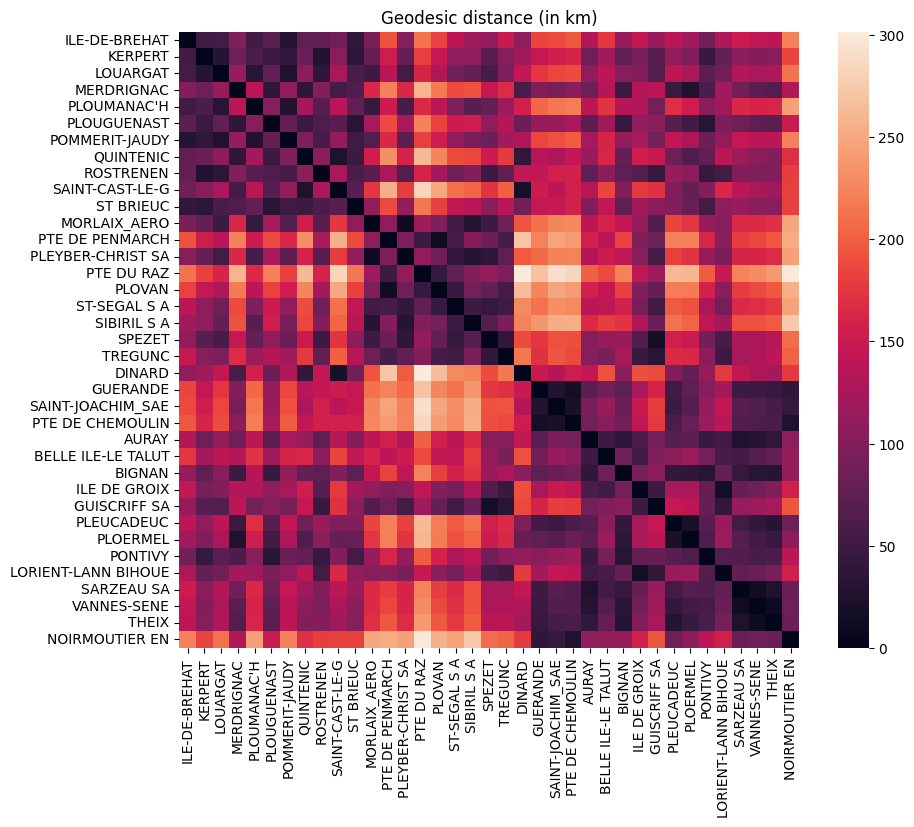

In [13]:
from scipy.spatial.distance import pdist, squareform
import seaborn as sns

dist_mat_square = squareform(pdist(station_np, metric = geodesic))

plt.figure(figsize=(10, 8))
sns.heatmap(dist_mat_square, xticklabels=stations_df.Nom, yticklabels=stations_df.Nom, fmt=".2f")
plt.title("Geodesic distance (in km)")
plt.show()

In [14]:
from pygsp import graphs
import numpy as np
from scipy.spatial.distance import pdist, squareform

station_coordinates = station_np

thresholds = np.arange(0, 1, 1 / 100)

distance_matrix = pdist(station_coordinates, metric=geodesic)
bandwidth = np.median(distance_matrix)

results = []
for threshold in thresholds:
    adjacency_matrix = squareform(exponential_similarity(distance_matrix, bandwidth, threshold))
    avg_degree = np.mean(np.sum(adjacency_matrix, axis=1))
    graph = graphs.Graph(adjacency_matrix)
    is_connected = graph.is_connected(recompute=True)
    results.append((threshold, avg_degree, is_connected))

for threshold, avg_degree, is_connected in reversed(results):
    if avg_degree >= 3 and is_connected:
        print(f"Threshold: {threshold:.2f}\nAverage Degree: {avg_degree:.2f}")
        break


Threshold: 0.83
Average Degree: 3.84


## Smoothness graph

In [15]:


# Update temperature_df with stations to keep (non Nan values)

temp_df_keep = temp_df.loc[:, ~temp_df.columns.isin(remove_list)]


In [16]:
import pandas as pd


adjacency_matrix = squareform(exponential_similarity(distance_matrix, bandwidth, threshold))

#compute the graph

G = graphs.Graph(adjacency_matrix)

# compute laplacian with treshhold

laplacian_matrix = G.L.todense()

# compute smoothness
signals = temp_df_keep.to_numpy()
smoothness_ar = np.array([float(signal.T.dot(laplacian_matrix).dot(signal)) for signal in signals])

smoothness_df = pd.Series(data=smoothness_ar, index=temp_df_keep.index)

C:\Users\DAO.EZSPACE\AppData\Local\Temp\ipykernel_36576\1820095135.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  smoothness_ar = np.array([float(signal.T.dot(laplacian_matrix).dot(signal)) for signal in signals])


In [17]:

index_argmin = smoothness_df.argmin()
index_argmax = smoothness_df.argmax()

print(f'Signal is the least smooth : {smoothness_df.index[index_argmax]}')
print(f'Signal is the smoothest : {smoothness_df.index[index_argmin]}')

Signal is the least smooth : 2014-01-21 06:00:00
Signal is the smoothest : 2014-01-24 19:00:00


Least smooth signal graph:


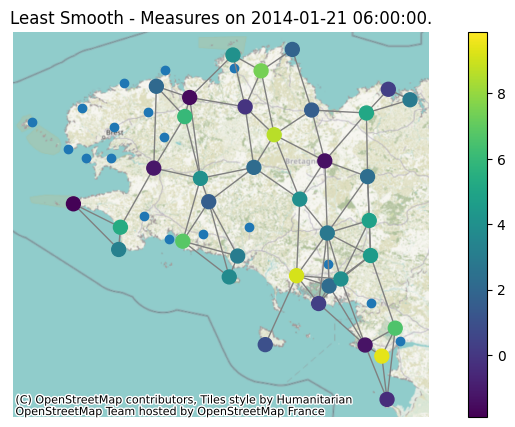

Smoothest signal graph:


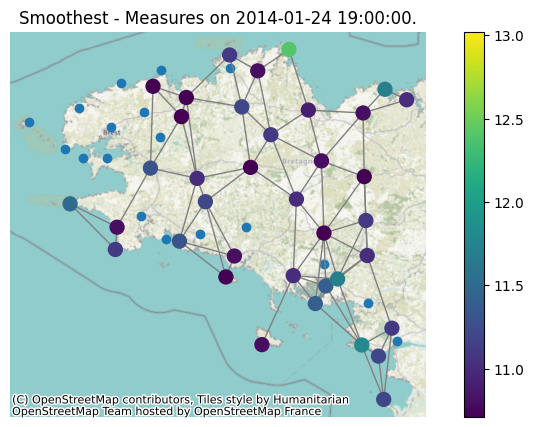

In [18]:
print(f'Least smooth signal graph:')
signal = temp_df_keep.iloc[index_argmax].to_numpy()
ax = stations_gdf.geometry.plot(figsize=(10, 5))
cx.add_basemap(ax, crs=stations_gdf.crs.to_string(), zoom=8)
ax.set_axis_off()
G.set_coordinates(station_np)
G.plot_signal(signal, ax=ax)
ax.set_title(f"Least Smooth - Measures on {temp_df_keep.index[index_argmax]}.")
plt.savefig('plots_q4/least_smooth.png')
plt.show()

print(f'Smoothest signal graph:')
signal = temp_df_keep.iloc[index_argmin].to_numpy()

ax = stations_gdf.geometry.plot(figsize=(10, 5))
cx.add_basemap(ax, crs=stations_gdf.crs.to_string(), zoom=8)
ax.set_axis_off()
G.set_coordinates(station_np)
G.plot_signal(signal, ax=ax)
ax.set_title(f"Smoothest - Measures on {temp_df_keep.index[index_argmin]}.")
plt.savefig('plots_q4/smoothest.png')
plt.show()


# Question 5

In [19]:
!mkdir plots_q5

Un sous-r‚pertoire ou un fichier plots_q5 existe d‚j….


In [60]:
import scipy


adjacency_matrix = squareform(exponential_similarity(distance_matrix, bandwidth, threshold))

G = graphs.Graph(adjacency_matrix)

laplacian_matrix = G.L.todense()

eigenvalues, eigenvectors = scipy.linalg.eigh(laplacian_matrix)

index_sort = np.argsort(eigenvalues)

eigenvalues = eigenvalues.real[index_sort]
eigenvectors = eigenvectors[:, index_sort]


In [61]:
# We adapt previous function of Q4 for this question because we have eigenvalues

def g_m(lamb,a, m, M, R):
    lambda_n = a*(M+1-R)


    def g_u(x):
        return np.where(
            (-R * a <= x) & (x < 0),
            1 / 2 * (1 + np.cos(2 * np.pi * (x / (a * R) + 1 / 2))),
            0,
        )


    return g_u(lamb - a * m) * ((0<= lamb ) & (lamb <= lambda_n)) # here boolean condition and not a if for array compatibility


In [62]:
# Parameters

R = 3
M = 9
m_list = np.arange(1, M+1)
a = eigenvalues[-1]/(M + 1 - R)

## First timestamp

In [63]:
# Select the signal for the first timestamp available in the data

signal = np.array(temp_df_keep.loc[temp_df_keep.index[0]])

# compute FT for graph
signal_ft = eigenvectors.T @ signal

In [64]:
# select signal that corresponds to the first timestamp available
signal = np.array(temp_df_keep.loc[temp_df_keep.index[0]])

# compute FT for graph
signal_ft = eigenvectors.T @ signal

labels = []

# iterate over each node
for v in range(signal.shape[0]):

  W_v = []

  # iterate over m
  for m in m_list:

    W_v_m = np.sum(g_m(eigenvalues, a, m,M, R)*signal_ft*eigenvectors[v, :])
    W_v.append(W_v_m)


  labels.append(np.argmax([np.sum(np.array(W_v[:3])**2), np.sum(np.array(W_v[3:6])**2), np.sum(np.array(W_v[6:9])**2)])) # labels as describe in the question

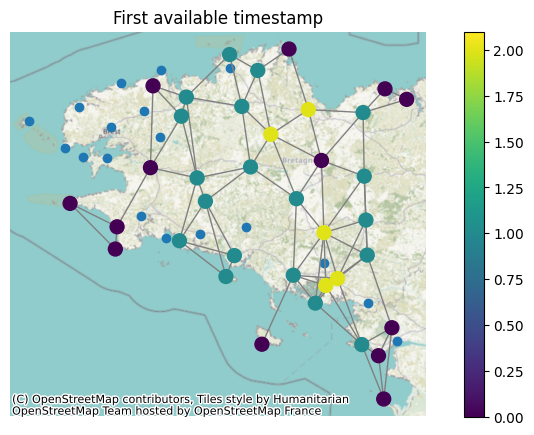

In [65]:
# display on the map the results
ax = stations_gdf.geometry.plot(figsize=(10, 5))
cx.add_basemap(ax, crs=stations_gdf.crs.to_string(), zoom=8)
ax.set_axis_off()
G.set_coordinates(station_np)
G.plot_signal(np.array(labels), ax=ax)
_ = ax.set_title(f"First available timestamp")

plt.savefig('plots_q5/map_first_timestamp.png')

## Smoothest signal

In [66]:
signal = np.array(temp_df_keep.loc[temp_df_keep.index[smoothness_df.argmin()]])


# compute FT for graph
signal_ft = eigenvectors.T @ signal

labels = []

# iterate over each node
for v in range(signal.shape[0]):

  W_v = []

  # iterate over m
  for m in m_list:

    W_v_m = np.sum(g_m(eigenvalues, a, m,M, R)*signal_ft*eigenvectors[v, :])
    W_v.append(W_v_m)


  labels.append(np.argmax([np.sum(np.array(W_v[:3])**2), np.sum(np.array(W_v[3:6])**2), np.sum(np.array(W_v[6:9])**2)])) # labels as describe in the question

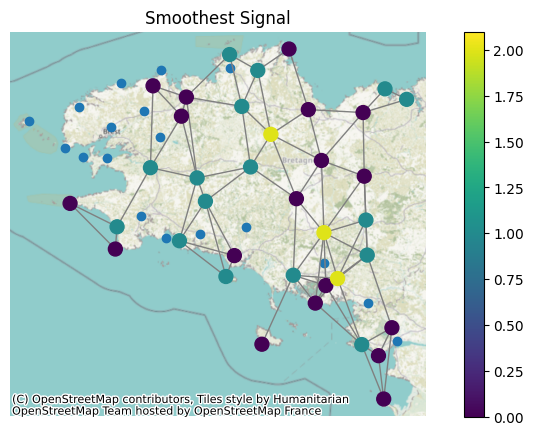

In [67]:
# display on the map the results
ax = stations_gdf.geometry.plot(figsize=(10, 5))
cx.add_basemap(ax, crs=stations_gdf.crs.to_string(), zoom=8)
ax.set_axis_off()
G.set_coordinates(station_np)
G.plot_signal(np.array(labels), ax=ax)

_ = ax.set_title(f"Smoothest Signal")

plt.savefig('plots_q5/map_smoothest_signal.png')

## Least Smooth signal

In [68]:
signal = np.array(temp_df_keep.loc[temp_df_keep.index[smoothness_df.argmax()]])


# compute FT for graph
signal_ft = eigenvectors.T @ signal

labels = []

# iterate over each node
for v in range(signal.shape[0]):

  W_v = []

  # iterate over m
  for m in m_list:

    W_v_m = np.sum(g_m(eigenvalues, a, m,M, R)*signal_ft*eigenvectors[v, :])
    W_v.append(W_v_m)


  labels.append(np.argmax([np.sum(np.array(W_v[:3])**2), np.sum(np.array(W_v[3:6])**2), np.sum(np.array(W_v[6:9])**2)])) # labels as describe in the question

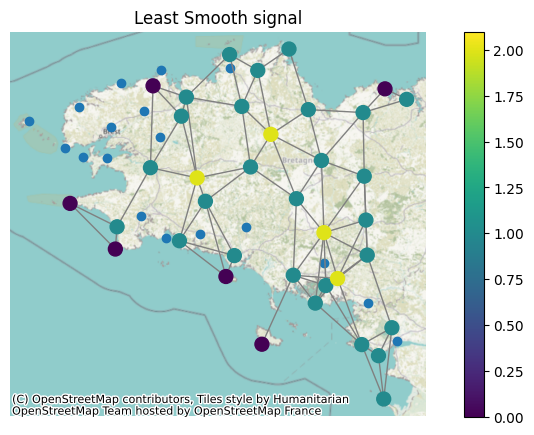

In [69]:
# display on the map the results
ax = stations_gdf.geometry.plot(figsize=(10, 5))
cx.add_basemap(ax, crs=stations_gdf.crs.to_string(), zoom=8)
ax.set_axis_off()
G_gaussian.set_coordinates(station_np)
G_gaussian.plot_signal(np.array(labels), ax=ax)

_ = ax.set_title(f"Least Smooth signal")

plt.savefig('plots_q5/map_least_smooth_signal.png')

# Question 6

In [49]:
!mkdir plots_q6

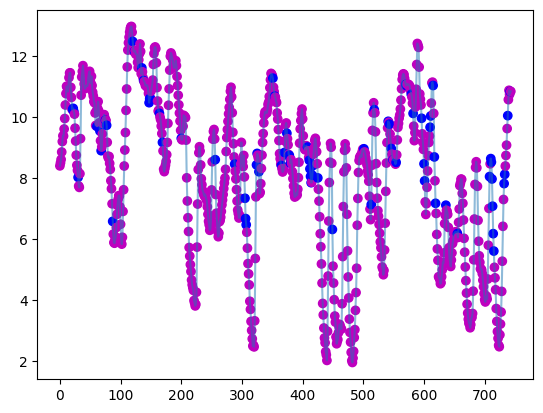

In [71]:
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt

def classify_signal(timestamp_index):
    signal = temp_df_keep.loc[temp_df_keep.index[timestamp_index]].to_numpy()
    signal_ft = eigenvectors.T @ signal
    labels = []

    for node in range(signal.shape[0]):
        wavelet_coefficients = [
            np.sum(g_m(eigenvalues, a, m, M, R) * signal_ft * eigenvectors[node, :])
            for m in m_list
        ]
        label = np.argmax([
            np.sum(np.array(wavelet_coefficients[:3]) ** 2),
            np.sum(np.array(wavelet_coefficients[3:6]) ** 2),
            np.sum(np.array(wavelet_coefficients[6:9]) ** 2)
        ])
        labels.append(label)

    majority_label = Counter(labels).most_common(1)[0][0]
    return majority_label

classes = [classify_signal(idx) for idx in range(temp_df_keep.shape[0])]

x_values = np.arange(temp_df_keep.shape[0])
y_values = temp_df_keep.mean(axis=1).to_numpy()
color_mapping = np.array(["b", "m", "r"])
node_colors = color_mapping[classes]

plt.plot(x_values, y_values, alpha=0.5)
plt.scatter(x_values, y_values, c=node_colors)
plt.savefig('plots_q6/temp_q6.png', bbox_inches='tight')
plt.show()


# Question 7

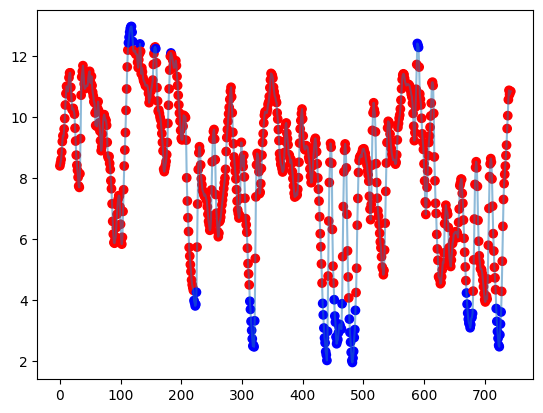

In [76]:
import numpy as np
import scipy.linalg
from collections import Counter
import matplotlib.pyplot as plt


nb_nodes, dim_t  = signals.shape

def compute_labels(signals, eigenvalues, eigenvectors, M, R):
    nb_nodes, dim_t = signals.shape
    eigenvalues_H = np.kron(eigenvalues_time, np.ones(dim_t)) + np.kron(np.ones(nb_nodes), eigenvalues)
    eigenvectors_H = np.kron(eigenvectors_time, eigenvectors)
    signal_ft = eigenvectors_H.T @ signals.flatten()
    labels = []
    a = eigenvalues_H[-1] / (M + 1 - R)

    for v in range(nb_nodes * dim_t):
        wavelet_coefficients = [
            np.sum(g_m(eigenvalues_H, a, m,M, R) * signal_ft * eigenvectors_H[v, :])
            for m in m_list
        ]
        label = np.argmax([
            np.sum(np.array(wavelet_coefficients[:3]) ** 2),
            np.sum(np.array(wavelet_coefficients[3:6]) ** 2),
            np.sum(np.array(wavelet_coefficients[6:9]) ** 2),
        ])
        labels.append(label)

    labels_per_node = np.array(labels).reshape((nb_nodes, dim_t))
    class_array = np.array([
        Counter(node_labels).most_common(1)[0][0] for node_labels in labels_per_node
    ])

    return class_array

eigenvalues, eigenvectors = scipy.linalg.eigh(G_gaussian.L.todense())
eigenvectors = eigenvectors.astype(np.float32)
Lap_t = -np.eye(nb_nodes, 1) - np.eye(nb_nodes, 1).T + np.eye(nb_nodes)
Lap_t[1:-1, 1:-1] += np.eye(nb_nodes - 2)
eigenvalues_time, eigenvectors_time = scipy.linalg.eigh(Lap_t)
eigenvectors_time = eigenvectors_time.astype(np.float32)

class_array = compute_labels(signals, eigenvalues, eigenvectors, M=11, R=3)
y = temp_df_keep.mean(axis=1)
x = np.arange(y.shape[0])
colors = np.array(["b", "m", "r"])
color_array = colors[class_array.astype(int)]

fig, ax = plt.subplots()
ax.plot(x, y, alpha=0.5)
ax.scatter(x, y, c=color_array)
plt.savefig('plots_q7/q7.png', bbox_inches='tight')
plt.show()
